In [1]:
#Project Imports

import pandas as pd
from pandas import Series
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from functools import reduce

import requests



from sklearn.linear_model import LinearRegression,Lasso,Ridge,RidgeCV,LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import neighbors


from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.features.importances import FeatureImportances

from sodapy import Socrata



from functools import reduce
from datetime import timezone, datetime,date
import pytz

pac = pytz.timezone('America/Los_Angeles')
utc = pytz.timezone('UTC')
%matplotlib inline

In [2]:
#load bike data from Seatlle data API
socrata_domain = 'data.seattle.gov'
socrata_dataset_identifier = '65db-xm6k'
socrata_token  = 'uTBE5rW06JBkufq8UsBellVPy'

client = Socrata(socrata_domain, socrata_token)

results = client.get(socrata_dataset_identifier 
                     ,where= "Date >= '2010-11-01T03:00:00.000' "
                     ,limit = 100000
                    )
fremont = pd.DataFrame.from_records(results)

In [3]:
#Convert date column and set as index

fremont['date'] = pd.to_datetime(fremont.date)
fremont.set_index('date',inplace = True)
fremont.index.names =['Date_Join']

#Convert to numeric columns
fremont['fremont_bridge_nb'] = pd.to_numeric(fremont['fremont_bridge_nb'])
fremont['fremont_bridge_sb'] = pd.to_numeric(fremont['fremont_bridge_sb'])


#Set timezone and sort index
fremont = fremont.tz_localize(pac,ambiguous = True, nonexistent = 'shift_forward')
fremont.sort_index(inplace = True)

#rename
fremont.rename(columns = {'fremont_bridge_nb' : 'EastSide',
                         'fremont_bridge_sb':'WestSide'
                         } , inplace= True)

#FillNA values with mean
fremont['WestSide'].fillna(value = fremont['WestSide'].mean(),inplace = True)
fremont['EastSide'].fillna(value = fremont['EastSide'].mean(),inplace = True)


#calculated Columns
fremont['Mean_Xing'] = fremont[['WestSide','EastSide']].mean(axis=1)
fremont['Total_Xing'] = fremont[['EastSide','WestSide']].sum(axis=1)
fremont['Time_of_Day'] = fremont.index.strftime('%H')
fremont['Month'] = fremont.index.strftime('%m')



print('You have Bridge data from {} to {}'.format(fremont.index.min().strftime('%m/%d/%Y-%I%p'),fremont.index.max().strftime('%m/%d/%Y-%I%p')))
print('There are {} observations and {} columns'.format(fremont.shape[0],fremont.shape[1]))
print(fremont.dtypes)

You have Bridge data from 10/03/2012-12AM to 05/31/2019-11PM
There are 58368 observations and 6 columns
EastSide       float64
WestSide       float64
Mean_Xing      float64
Total_Xing     float64
Time_of_Day     object
Month           object
dtype: object


In [4]:
fremont_d = fremont.resample('D').sum()
fremont_d['Month'] = fremont_d.index.strftime('%m')
fremont_d['WeekDay'] = fremont_d.index.strftime('%A')

In [5]:
path = "./Data/Daily_Summaries/Daily_Summaries_Merged.csv"
d = ","
wx = pd.read_csv(path,delimiter=d)
wx.DATE = pd.to_datetime(wx.DATE)
wx.rename(columns={'DATE':'Date_Join'},inplace = True)
wx.drop(['LATITUDE','LONGITUDE'],axis = 1,inplace=True)
#FillNA values with mean
wx['TMAX'].fillna(value = wx['TMAX'].mean(),inplace = True)
wx['TMIN'].fillna(value = wx['TMIN'].mean(),inplace = True)
;

''

In [6]:
wx.loc[wx['STATION'] == 'USW00024233', 'NAME'] = 'SeaTac'
wx.loc[wx['STATION'] == 'USW00024234', 'NAME'] = 'Boeing_Field'
wx.loc[wx['STATION'] == 'US1WAKG0079', 'NAME'] = 'Magnolia'
wx.loc[wx['STATION'] == 'US1WAKG0145', 'NAME'] = 'Phinney'
wx.loc[wx['STATION'] == 'US1WAKG0200', 'NAME'] = 'Georgetown'
wx.loc[wx['STATION'] == 'US1WAKG0199', 'NAME'] = 'GreenWood'
wx.loc[wx['STATION'] == 'US1WAKG0225', 'NAME'] = 'Cap_Hill'
wx.loc[wx['STATION'] == 'US1WAKG0239', 'NAME'] = 'Woodland_Park'

In [7]:
#average WX observations together to get daily totals
wx_d = wx.groupby(by = 'Date_Join')[['PRCP','TMAX','TMIN']].mean()
wx_d = wx_d.tz_localize(pac,ambiguous = True, nonexistent = 'shift_forward')
wx_d['Rain_Day'] = (wx_d['PRCP'] > .1)
print('You have WX data from {} to {}'.format(wx_d.index.min().strftime('%m/%d/%Y-%I%p'),wx_d.index.max().strftime('%m/%d/%Y-%I%p')))

You have WX data from 01/01/2010-12AM to 05/15/2019-12AM


In [8]:
data = fremont_d.merge(wx_d, how = 'inner',left_on = 'Date_Join',right_on = 'Date_Join')
data = pd.get_dummies(data=data, columns = ['Month','Rain_Day','WeekDay'])


''

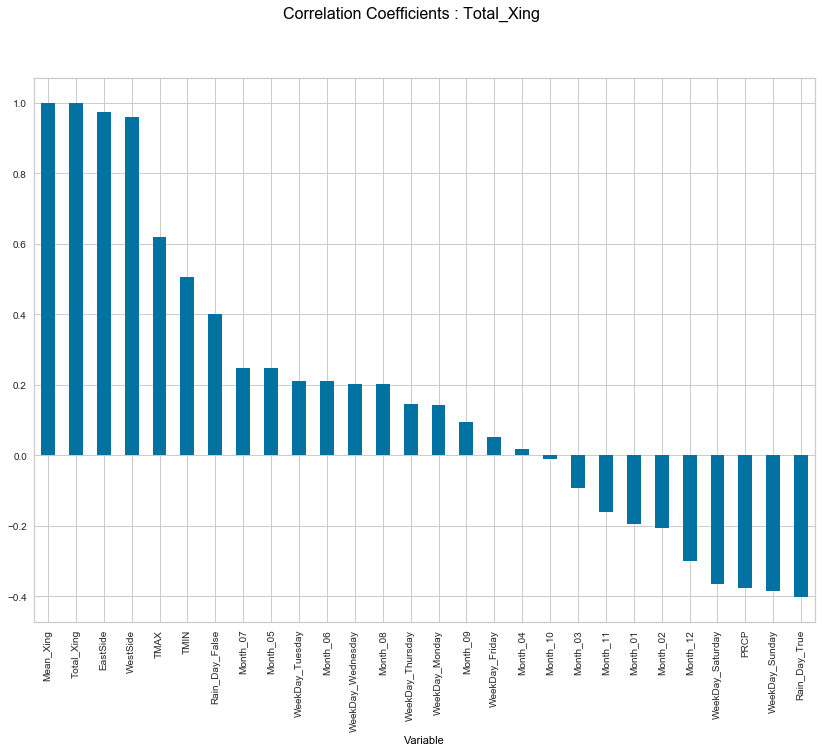

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize = [14,10],)
corr = data.corr()
corr['Total_Xing'].sort_values(ascending=False).plot(kind='bar',ax=ax)
ax.set_xlabel("Variable", color="black")
#ax.set_xlabel("Correlation Coefficient", color="black")
fig.suptitle('Correlation Coefficients : Total_Xing', fontsize=16,color='black')
plt.savefig('./Figures/Daily_Coefficients.png')
;

In [10]:
features = [
    'PRCP',
    'TMAX',
    'TMIN', 
    'Month_01',
    'Month_02',
    'Month_03',
    'Month_04',
    'Month_05',
    'Month_06',
    'Month_07',
    'Month_08',
    'Month_09',
    'Month_10',
    'Month_11',
    'Month_12',
    'Rain_Day_False',
    'Rain_Day_True',
    'WeekDay_Monday',
    'WeekDay_Tuesday',
    'WeekDay_Wednesday',
    'WeekDay_Thursday',
    'WeekDay_Friday',
    'WeekDay_Saturday',
    'WeekDay_Sunday'
]

In [11]:
X = data[features]


#y = data['EastSide']
#y = data['WestSide']
#y = data['Mean_Xing']
y = data['Total_Xing']


scaler = StandardScaler()
X_std = scaler.fit_transform(X)

C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state= 23)
#X_train, X_test, y_train, y_test = train_test_split(X_std, y,random_state= 23)


#y_baseline = [data.EastSide.mean()] * len(y_test)
#y_baseline = [data.WestSide.mean()] * len(y_test)
#y_baseline = [data.Mean_Xing.mean()] * len(y_test)
y_baseline = [data.Total_Xing.mean()] * len(y_test)


print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

print(len(y_baseline))

(1812, 24)
(1812,)
(604, 24)
(604,)
604


In [13]:
model = Ridge(alpha=5)
#model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#save model coeficients
coef = Series(model.coef_,features).sort_values(ascending=False)

#set negative predictons to 0???
#y_pred[y_pred < 0] = 10

print("R-squared = ", model.score(X_test, y_test)) 
print("RMSE = ",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("Baseline RMSE = ",np.sqrt(metrics.mean_squared_error(y_test, y_baseline)))

R-squared =  0.8351626041400437
RMSE =  535.0314048903153
Baseline RMSE =  1317.9939129017212


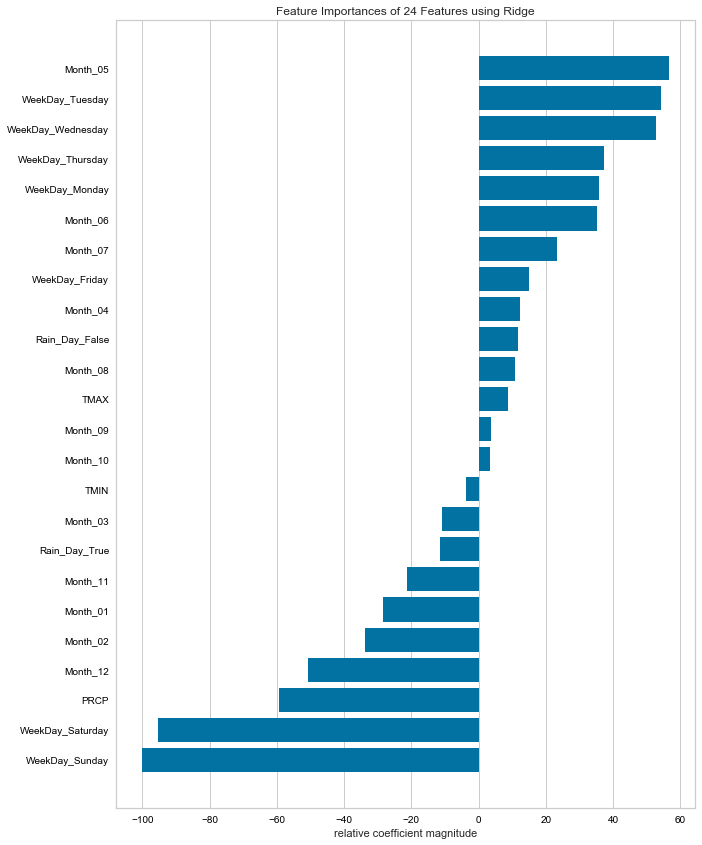

In [14]:
with plt.rc_context({'xtick.color':'black', 'ytick.color':'black','font.size' : '15','lines.markersize': '15.0'}):
    fig, ax = plt.subplots(figsize=(10,12))


    visualizer = FeatureImportances(model,ax=ax)
    visualizer.fit(X_train, y_train)
    visualizer.poof(ax=ax)
    #ax.set_xlabel("Relative Coefficient Magnitude", color="black",size=15)
    #ax.set_ylabel('Temp', color="black",size=15)
    #ax.set_title('Feature Importances of 86 predictors using Ridge',color='black',size=25)

''

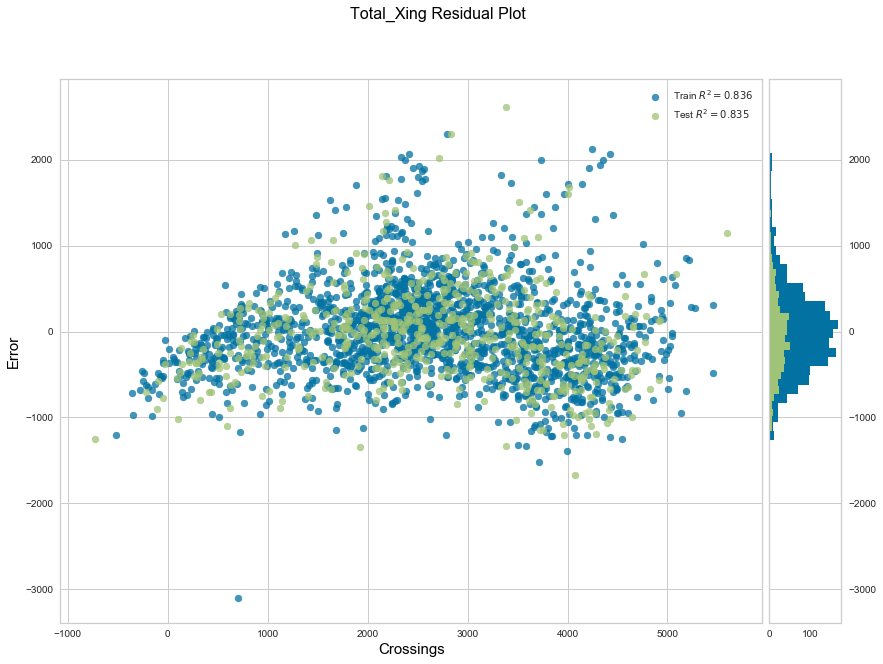

In [87]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize = [14,10])

visualizer = ResidualsPlot(model,ax=ax)
visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
#visualizer.poof()                 # Draw/show/poof the data



ax.set_xlabel("Crossings", color="black",size=15)
ax.set_ylabel("Error", color="black",size=15)
#ax.xtick.color('red')
fig.suptitle('Total_Xing Residual Plot', fontsize=16,color='black')

plt.legend()

#plt.show(visualizer)
#plt.show(visualizer.poof(ax=ax) )
plt.savefig('./Figures/Residuals_Daily_Total_Xing.png')


#g = visualizer.poof(ax=ax)             # Draw/show/poof the data
;

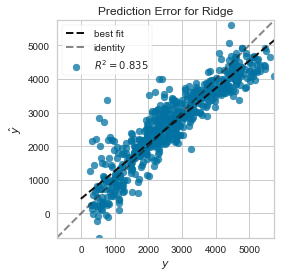

In [95]:
visualizer = PredictionError(model)

#visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()             # Draw/show/poof the data

In [93]:
y_test.sort_values()

Date_Join
2015-12-25 00:00:00-08:00     264.0
2018-12-09 00:00:00-08:00     292.0
2018-12-29 00:00:00-08:00     319.0
2018-11-22 00:00:00-08:00     325.0
2015-01-04 00:00:00-08:00     339.0
2018-12-16 00:00:00-08:00     352.0
2017-02-04 00:00:00-08:00     353.0
2017-02-06 00:00:00-08:00     368.0
2012-11-18 00:00:00-08:00     392.0
2018-02-18 00:00:00-08:00     426.0
2016-03-27 00:00:00-07:00     446.0
2014-12-25 00:00:00-08:00     451.0
2017-03-26 00:00:00-07:00     466.0
2016-12-31 00:00:00-08:00     472.0
2017-03-11 00:00:00-08:00     474.0
2014-02-16 00:00:00-08:00     485.0
2012-12-29 00:00:00-08:00     487.0
2015-12-20 00:00:00-08:00     512.0
2015-11-07 00:00:00-08:00     525.0
2012-12-02 00:00:00-08:00     527.0
2012-10-27 00:00:00-07:00     531.0
2015-11-26 00:00:00-08:00     532.0
2017-12-26 00:00:00-08:00     554.0
2017-02-19 00:00:00-08:00     564.0
2018-01-27 00:00:00-08:00     565.0
2013-12-07 00:00:00-08:00     591.0
2015-01-17 00:00:00-08:00     592.0
2015-12-24 00:00:0

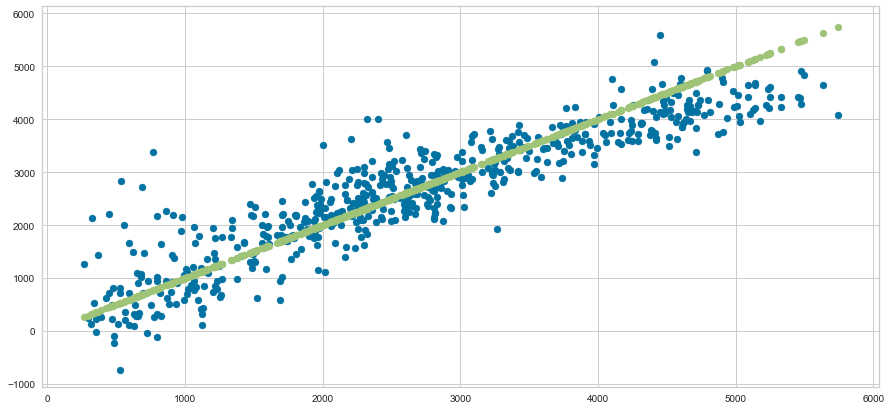

In [90]:
plt.figure(figsize = (15,7))
plt.scatter(x=y_test,y=y_pred, color = 'b')
#plt.scatter(x=y_test,y=y_test, color = 'g')